In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [4]:
import pandas as pd
from pandas import DataFrame
train = pd.read_csv("/content/gdrive/MyDrive/Mercari/train.tsv", sep="\t")
test=pd.read_csv('/content/gdrive/MyDrive/Mercari/test_stg2.tsv',sep="\t")

In [5]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [6]:
test.isnull().sum()

test_id                    0
name                       0
item_condition_id          0
category_name          14833
brand_name           1476490
shipping                   0
item_description           6
dtype: int64

In [7]:
category_split_arr = []
def category_split(category_name):
    try:
        val1,val2,val3=category_name.split('/')
        return val1,val2,val3
    except:
        return ('Missing', 'Missing', 'Missing')

In [8]:
train['main_category'], train['sub_category'], train['item_category'] =zip(*train['category_name'].apply(lambda x: category_split(x)))

In [9]:
test['main_category'], test['sub_category'], test['item_category'] =zip(*test['category_name'].apply(lambda x: category_split(x)))

In [10]:
# Drop category_name feature
train=train.drop(['category_name'],axis=1)
test=test.drop(["category_name"],axis=1)

In [11]:
train=train[(train['price']>3) & (train['price']<2000)]

In [12]:
train['brand_name'] = train['brand_name'].fillna(value='other_null')
test['brand_name'] = test['brand_name'].fillna(value='other_null')

In [13]:
train['item_description'] = train['item_description'].fillna(value='no_description_yet')
test['item_description'] = test['item_description'].fillna(value='no_description_yet')

In [14]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [17]:
# Preprocessing on item_description train data.
train['item_description'] = preprocess(train['item_description'],stopword=True)

100%|██████████| 1462949/1462949 [02:19<00:00, 10502.45it/s]


In [18]:
# Preprocessing on item_description test data.
test['item_description'] = preprocess(test['item_description'],stopword=True)

100%|██████████| 3460725/3460725 [05:24<00:00, 10677.90it/s]


In [19]:
train['name'] = preprocess(train['name'],stopword=False)

100%|██████████| 1462949/1462949 [00:34<00:00, 42621.34it/s]


In [20]:
test['name'] = preprocess(test['name'],stopword=False)

100%|██████████| 3460725/3460725 [01:18<00:00, 43908.60it/s]


In [21]:
import numpy as np
train['log_price'] = np.log1p(train['price'])

In [22]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(train,test_size=0.33)

In [23]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vec = tfidf_desc = CountVectorizer()
X_train_name = vec.fit_transform(df_train['name'])
X_test_name = vec.transform(df_test['name'])
test_name = vec.transform(test['name'])

In [24]:
print(X_train_name.shape)

(980175, 83402)


In [25]:
%%time
tfidf_desc = TfidfVectorizer(max_features=100000, ngram_range=(1, 3), stop_words='english')
X_train_desc= tfidf_desc.fit_transform(df_train['item_description'])
X_test_desc= tfidf_desc.transform(df_test['item_description'])
test_desc= tfidf_desc.transform(test['item_description'])

CPU times: user 4min 37s, sys: 3.53 s, total: 4min 41s
Wall time: 4min 40s


In [26]:
print(X_train_desc.shape)

(980175, 100000)


In [27]:
%%time
from sklearn.preprocessing import LabelBinarizer
lb_brand_name = LabelBinarizer(sparse_output=True)
X_train_brand = lb_brand_name.fit_transform(df_train['brand_name'])
X_test_brand = lb_brand_name.transform(df_test['brand_name'])
test_brand = lb_brand_name.transform(test['brand_name'])

CPU times: user 5min 12s, sys: 766 ms, total: 5min 13s
Wall time: 5min 12s


In [28]:
  %%time
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_train_item_condition_id = lb_item_cond_id.fit_transform(df_train['item_condition_id'])
X_test_item_condition_id = lb_item_cond_id.transform(df_test['item_condition_id'])
test_item_condition_id = lb_item_cond_id.transform(test['item_condition_id'])

CPU times: user 478 ms, sys: 1.99 ms, total: 480 ms
Wall time: 479 ms


In [29]:
%%time
lb_shipping = LabelBinarizer(sparse_output=True)
X_train_shipping = lb_shipping.fit_transform(df_train['shipping'])
X_test_shipping = lb_shipping.transform(df_test['shipping'])
test_shipping = lb_shipping.transform(test['shipping'])

CPU times: user 521 ms, sys: 3 ms, total: 524 ms
Wall time: 520 ms


In [30]:
%%time
lb_cat = LabelBinarizer(sparse_output=True)
X_train_main = lb_cat.fit_transform(df_train['main_category'])
X_test_main = lb_cat.transform(df_test['main_category'])
test_main = lb_cat.transform(test['main_category'])

CPU times: user 24.2 s, sys: 77.5 ms, total: 24.3 s
Wall time: 24.1 s


In [31]:
%%time
lb_cat = LabelBinarizer(sparse_output=True)
X_train_sub = lb_cat.fit_transform(df_train['sub_category'])
X_test_sub = lb_cat.transform(df_test['sub_category'])
test_sub= lb_cat.transform(test['sub_category'])

CPU times: user 53.3 s, sys: 156 ms, total: 53.4 s
Wall time: 53.1 s


In [32]:
%%time
lb_cat = LabelBinarizer(sparse_output=True)
X_train_item = lb_cat.fit_transform(df_train['item_category'])
X_test_item = lb_cat.transform(df_test['item_category'])
test_item= lb_cat.transform(test['item_category'])

CPU times: user 3min 48s, sys: 538 ms, total: 3min 49s
Wall time: 3min 48s


In [33]:
%%time
from scipy.sparse import hstack
train_s=hstack((X_train_desc,X_train_name,X_train_brand,X_train_item_condition_id,X_train_shipping,X_train_main,X_train_sub,X_train_item)).tocsr().astype('float32')
test_s=hstack((X_test_desc,X_test_name,X_test_brand,X_test_item_condition_id,X_test_shipping,X_test_main,X_test_sub,X_test_item)).tocsr().astype('float32')
test_final_s=hstack((test_desc,test_name,test_brand,test_item_condition_id,test_shipping,test_main,test_sub,test_item)).tocsr().astype('float32')

CPU times: user 8.72 s, sys: 816 ms, total: 9.53 s
Wall time: 9.49 s


In [34]:
y_train=df_train['log_price'].values
y_test=df_test['log_price'].values

In [35]:
from tensorflow.keras import regularizers
def simple_mlp_model1(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(192,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.30)(out)
    out = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.15)(out)
    out = Dense(1)(out)
    model = Model(model_in, out)
    return model

In [36]:
model_1 = simple_mlp_model1(train_s.shape[1])
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 188701)]          0         
_________________________________________________________________
dense (Dense)                (None, 192)               36230784  
_________________________________________________________________
batch_normalization (BatchNo (None, 192)               768       
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [37]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K

def root_mean_squared_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [38]:
model_1.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError(),root_mean_squared_log_error])

In [39]:
from tensorflow.keras.callbacks import *
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_root_mean_squared_log_error', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_root_mean_squared_log_error',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_root_mean_squared_log_error', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard]

In [40]:
history_1 =model_1.fit(x=train_s, y=y_train,epochs=50,verbose=1,callbacks=callbacks,batch_size=1024,validation_data=(test_s, y_test))

Epoch 1/50
958/958 [==============================] - 19s 16ms/step - loss: 2.1731 - root_mean_squared_error: 1.2055 - root_mean_squared_log_error: 1.0342 - val_loss: 0.6209 - val_root_mean_squared_error: 0.4862 - val_root_mean_squared_log_error: 0.4859

Epoch 00001: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 2/50
958/958 [==============================] - 16s 16ms/step - loss: 0.5960 - root_mean_squared_error: 0.5676 - root_mean_squared_log_error: 0.5667 - val_loss: 0.4345 - val_root_mean_squared_error: 0.4706 - val_root_mean_squared_log_error: 0.4703

Epoch 00002: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 3/50
958/958 [==============================] - 17s 16ms/step - loss: 0.4624 - root_mean_squared_error: 0.5184 - root_mean_squared_log_error: 0.5181 - val_loss: 0.3948 - val_root_mean_squared_error: 0.4606 - val_root_mean_squared_log_error: 0.4604

Epoch 00003: 

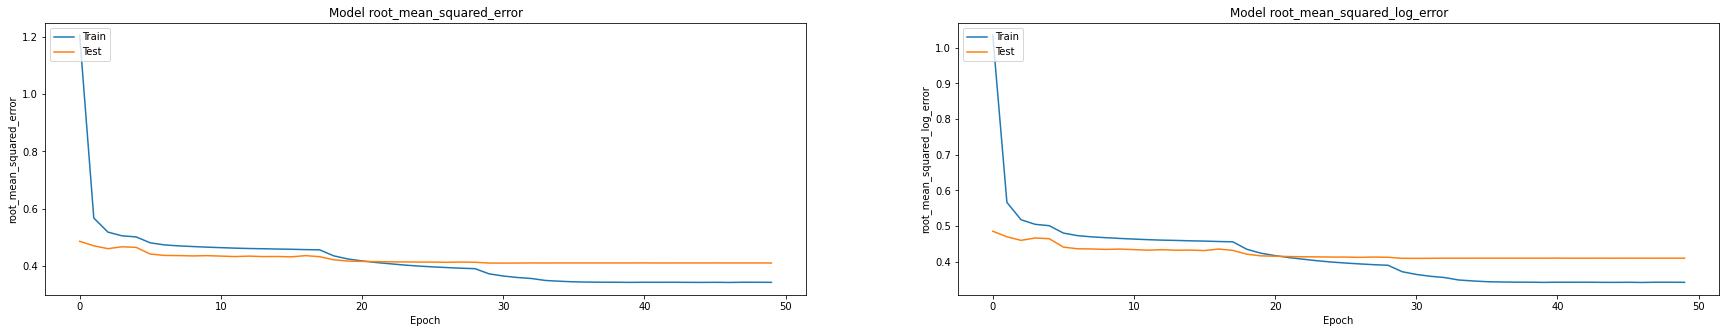

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_1.history['root_mean_squared_error'])
plt.plot(history_1.history['val_root_mean_squared_error'])
plt.title('Model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(history_1.history['root_mean_squared_log_error'])
plt.plot(history_1.history['val_root_mean_squared_log_error'])
plt.title('Model root_mean_squared_log_error')
plt.ylabel('root_mean_squared_log_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [42]:
model_1_pred=model_1.predict(test_final_s)

In [43]:
final_pred_1=np.expm1(model_1_pred)

In [44]:
submission=pd.read_csv('/content/gdrive/MyDrive/Mercari/sample_submission_stg2.csv')
submission.head()

,test_id,price
0,0,26.738
1,1,26.738
2,2,26.738
3,3,26.738
4,4,26.738


In [45]:
submission['price']=final_pred_1

In [46]:
submission.to_csv('DL_1_submission.csv')

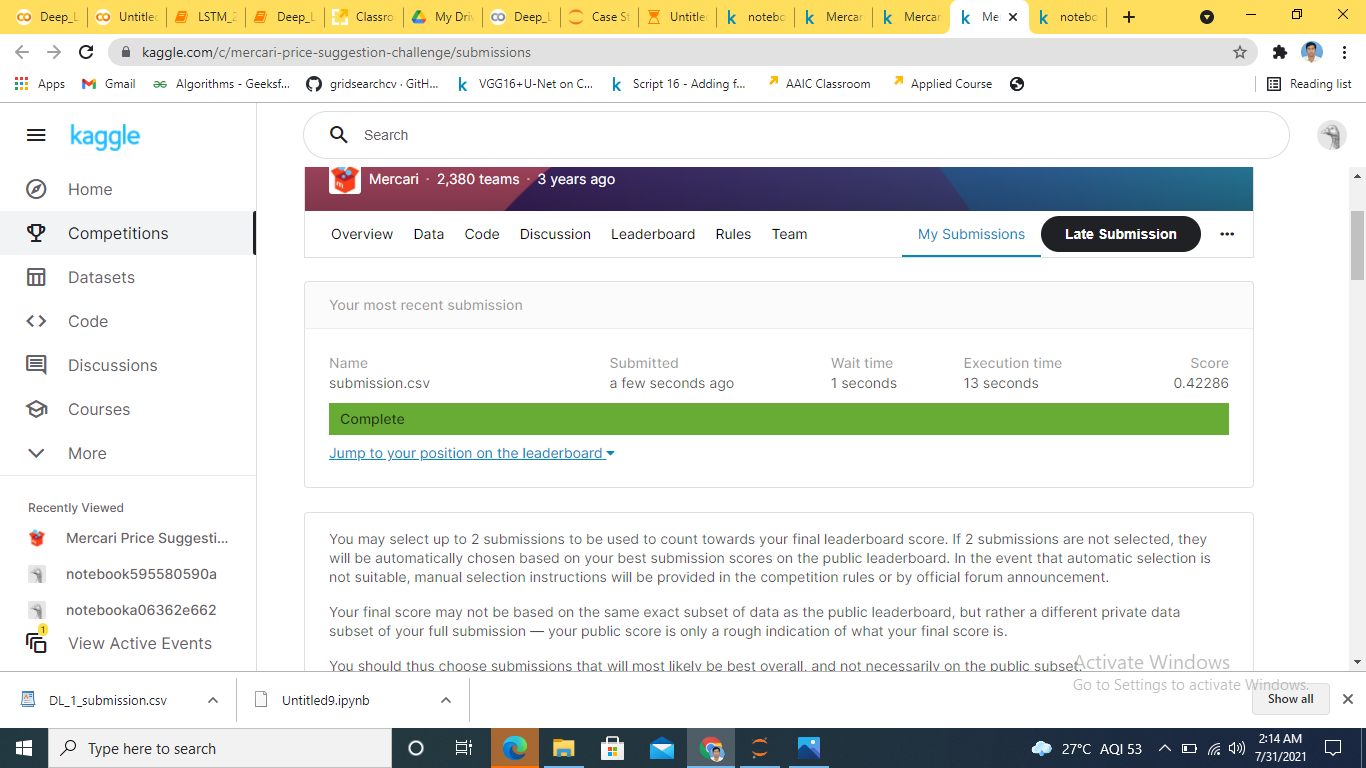

# Model:-2

In [47]:
from tensorflow.keras import regularizers
def simple_mlp_model2(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(192,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(1)(out)
    model = Model(model_in, out)
    return model

In [48]:
model_2=simple_mlp_model2(train_s.shape[1])

In [49]:
model_2.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError(),root_mean_squared_log_error])

In [50]:
from tensorflow.keras.callbacks import *
filepath="weights_2.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_root_mean_squared_log_error', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_root_mean_squared_log_error',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_root_mean_squared_log_error', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard]

In [52]:
history_2 =model_2.fit(x=train_s, y=y_train,epochs=50,verbose=1,callbacks=callbacks,batch_size=1024,validation_data=(test_s, y_test))

Epoch 1/50
958/958 [==============================] - 18s 17ms/step - loss: 0.1518 - root_mean_squared_error: 0.3509 - root_mean_squared_log_error: 0.3508 - val_loss: 0.1976 - val_root_mean_squared_error: 0.4110 - val_root_mean_squared_log_error: 0.4108

Epoch 00001: saving model to weights_2.best.hdf1
INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets
Epoch 2/50
958/958 [==============================] - 17s 16ms/step - loss: 0.1521 - root_mean_squared_error: 0.3513 - root_mean_squared_log_error: 0.3511 - val_loss: 0.1976 - val_root_mean_squared_error: 0.4110 - val_root_mean_squared_log_error: 0.4107

Epoch 00002: saving model to weights_2.best.hdf1
INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets
Epoch 3/50
958/958 [==============================] - 17s 16ms/step - loss: 0.1520 - root_mean_squared_error: 0.3512 - root_mean_squared_log_error: 0.3510 - val_loss: 0.1976 - val_root_mean_squared_error: 0.4110 - val_root_mean_squared_log_error: 0.4107

Epoch 00003: 

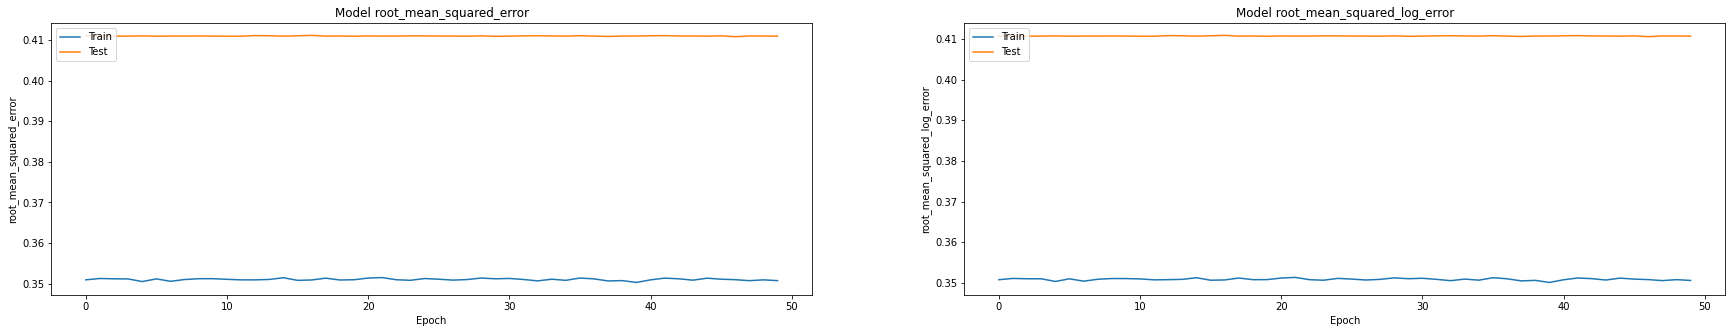

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_2.history['root_mean_squared_error'])
plt.plot(history_2.history['val_root_mean_squared_error'])
plt.title('Model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(history_2.history['root_mean_squared_log_error'])
plt.plot(history_2.history['val_root_mean_squared_log_error'])
plt.title('Model root_mean_squared_log_error')
plt.ylabel('root_mean_squared_log_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [69]:
model_2_pred=np.expm1(model_2.predict(test_final_s))

In [70]:
submission['price']=model_2_pred

In [71]:
submission.to_csv('DL_2_submission.csv',index=False)

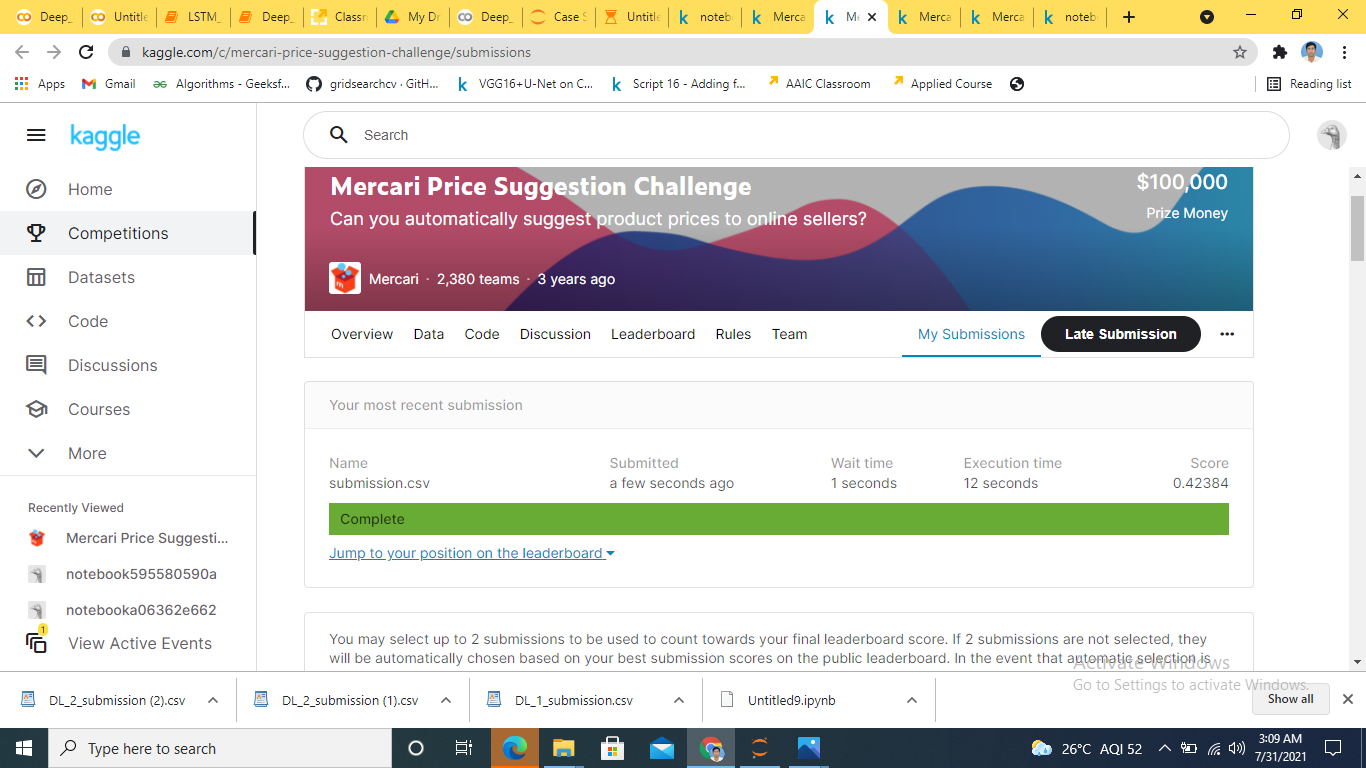

# Model:-3

In [72]:
from tensorflow.keras import regularizers
def simple_mlp_model3(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(192,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = BatchNormalization()(out)
    out = Dropout(0.75)(out)
    out = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.50)(out)
    out = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.25)(out)
    out = Dense(1)(out)
    model = Model(model_in, out)
    return model

In [73]:
model_3=simple_mlp_model3(train_s.shape[1])

In [74]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 188701)]          0         
_________________________________________________________________
dense_12 (Dense)             (None, 192)               36230784  
_________________________________________________________________
batch_normalization_9 (Batch (None, 192)               768       
_________________________________________________________________
dropout_9 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               24704     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0   

In [75]:
model_3.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError(),root_mean_squared_log_error])

In [76]:
from tensorflow.keras.callbacks import *
filepath="weights_3.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_root_mean_squared_log_error', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_root_mean_squared_log_error',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_root_mean_squared_log_error', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard]

In [77]:
history_3 =model_3.fit(x=train_s, y=y_train,epochs=50,verbose=1,callbacks=callbacks,batch_size=1024,validation_data=(test_s, y_test))

Epoch 1/50
958/958 [==============================] - 20s 18ms/step - loss: 2.7122 - root_mean_squared_error: 1.3220 - root_mean_squared_log_error: 1.1563 - val_loss: 0.7973 - val_root_mean_squared_error: 0.5055 - val_root_mean_squared_log_error: 0.5052

Epoch 00001: saving model to weights_3.best.hdf1
INFO:tensorflow:Assets written to: weights_3.best.hdf1/assets
Epoch 2/50
958/958 [==============================] - 18s 17ms/step - loss: 0.7364 - root_mean_squared_error: 0.6160 - root_mean_squared_log_error: 0.6151 - val_loss: 0.4884 - val_root_mean_squared_error: 0.4807 - val_root_mean_squared_log_error: 0.4804

Epoch 00002: saving model to weights_3.best.hdf1
INFO:tensorflow:Assets written to: weights_3.best.hdf1/assets
Epoch 3/50
958/958 [==============================] - 17s 16ms/step - loss: 0.5313 - root_mean_squared_error: 0.5579 - root_mean_squared_log_error: 0.5576 - val_loss: 0.4187 - val_root_mean_squared_error: 0.4747 - val_root_mean_squared_log_error: 0.4745

Epoch 00003: 

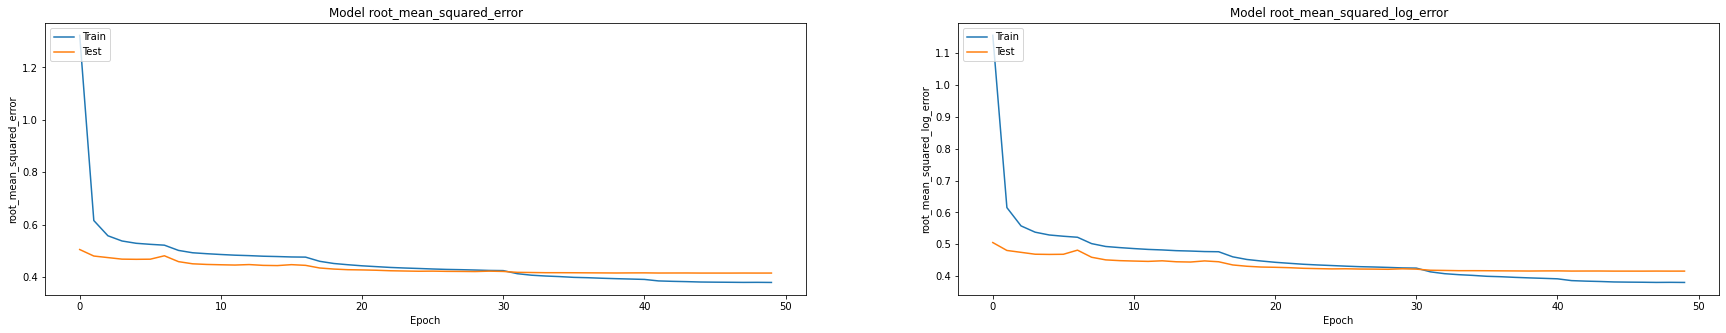

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_3.history['root_mean_squared_error'])
plt.plot(history_3.history['val_root_mean_squared_error'])
plt.title('Model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(history_3.history['root_mean_squared_log_error'])
plt.plot(history_3.history['val_root_mean_squared_log_error'])
plt.title('Model root_mean_squared_log_error')
plt.ylabel('root_mean_squared_log_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [79]:
model_3_pred=np.expm1(model_3.predict(test_final_s))

In [81]:
submission['price']=model_3_pred

In [82]:
submission.head()

,test_id,price
0,0,6.789835
1,1,9.868517
2,2,58.535465
3,3,12.118794
4,4,7.957420


In [83]:
submission.to_csv('DL_3_submission.csv')

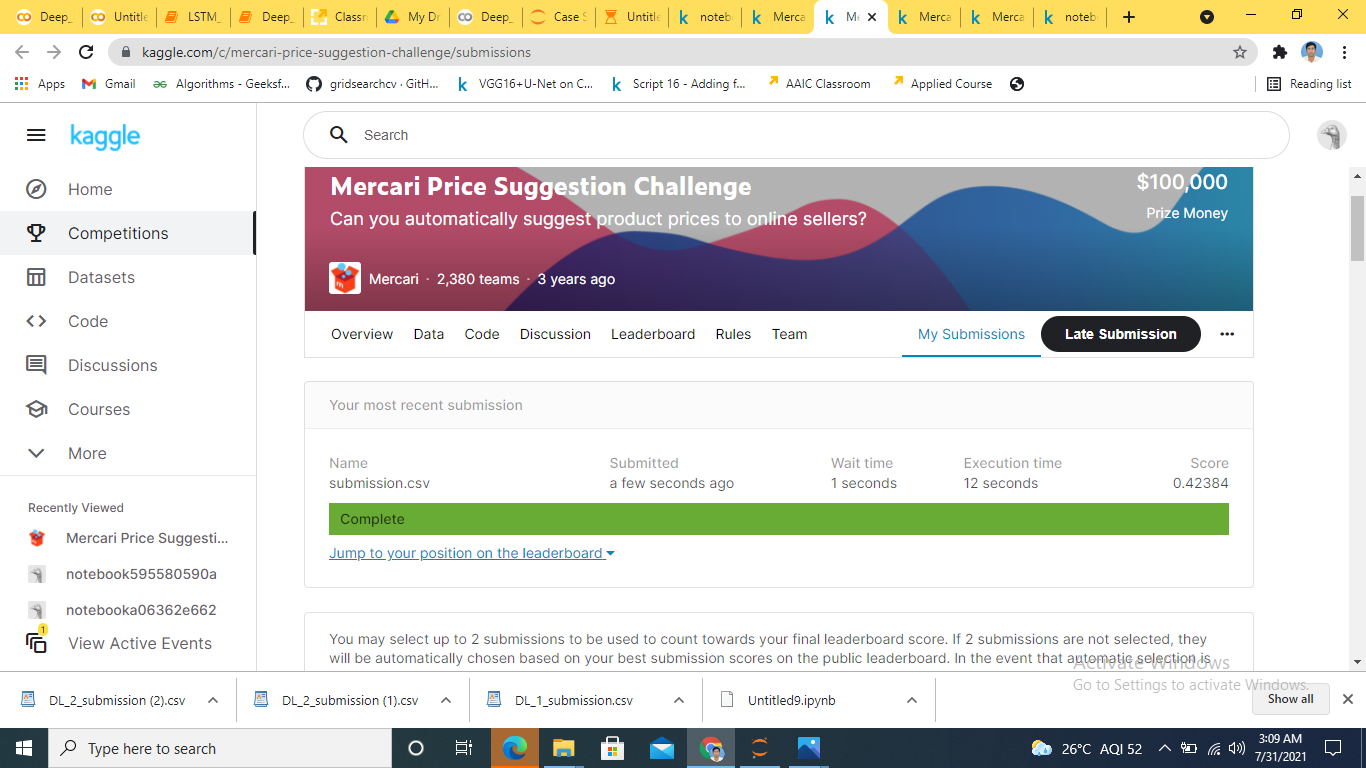

# Ensemble

In [ ]:
model_1_pred_new= np.expm1(model_1.predict(X_test))
model_3_pred_new = np.expm1(model_3.predict(X_test))

In [ ]:
weights = list(np.linspace(0.1,1,25))
scores = []

In [ ]:
scores=[]
from tqdm import tqdm
for w in tqdm(weights):
    pred= (w*model_1_pred_new) + (1-w)*(model_3_pred_new)
    scores.append(root_mean_squared_log_error(y_test,pred))

100%|██████████| 25/25 [00:00<00:00, 304.54it/s]


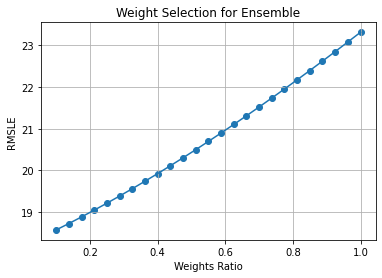

In [ ]:
import matplotlib.pyplot as plt
plt.plot(weights, scores)
plt.scatter(weights, scores)
plt.xlabel("Weights Ratio")
plt.ylabel("RMSLE")
plt.title("Weight Selection for Ensemble")
plt.grid()
plt.show()

In [ ]:
df = pd.DataFrame({'weights' : weights,'scores':scores})
df.head(5)

,weights,scores
0,0.1000,"tf.Tensor(18.57344637601565, shape=(), dtype=f..."
1,0.1375,"tf.Tensor(18.726841322808653, shape=(), dtype=..."
2,0.1750,"tf.Tensor(18.884858051081167, shape=(), dtype=..."
3,0.2125,"tf.Tensor(19.04738452833736, shape=(), dtype=f..."
4,0.2500,"tf.Tensor(19.214303177361245, shape=(), dtype=..."


In [ ]:
w = df.weights[df.scores == min(df.scores)].values[0]
print(w)

0.1


In [ ]:
final_pred= ((w*model_1_pred) + ((1-w)*model_3_pred))

In [ ]:
submission['price']=final_pred

In [ ]:
submission.to_csv('DL_ensemble_submission.csv')

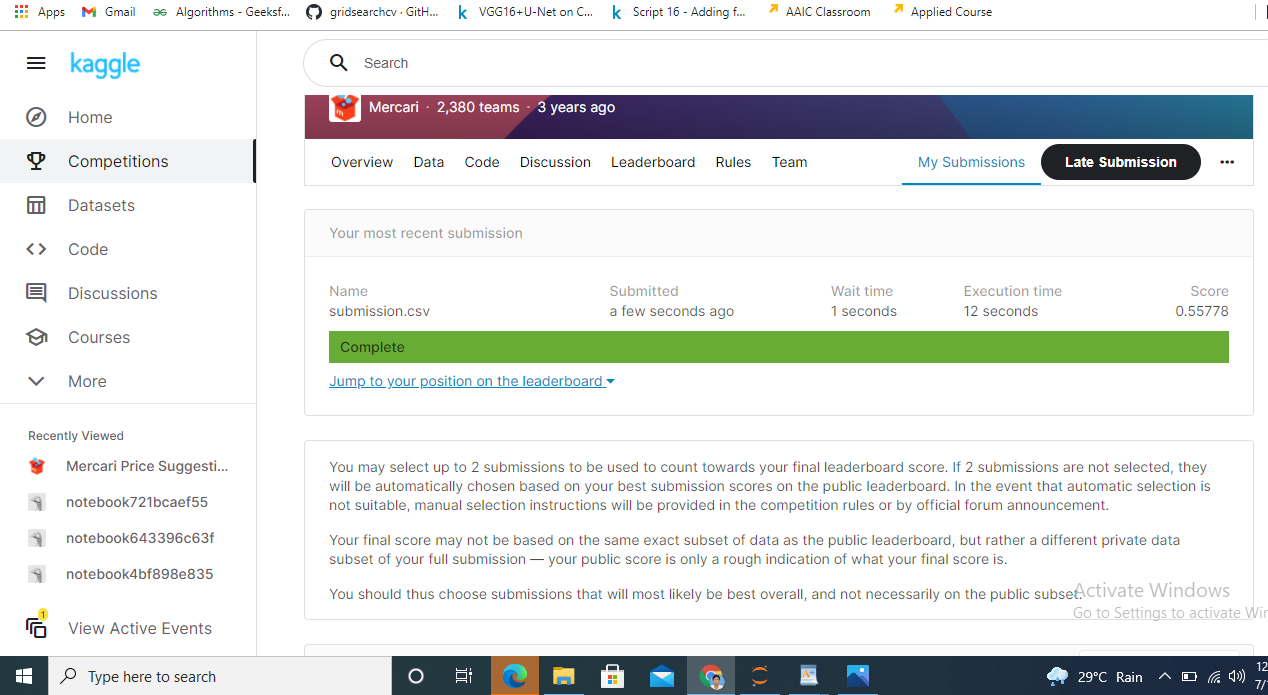